In [1]:
!pip install etherscan-python

In [24]:
import pandas as pd
import numpy as np
import requests
import json
import time
import re
import logging
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Suppress potential warnings from empty slices
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Data Collection

In [3]:
# --- Etherscan API Setup ---
ETHERSCAN_API_KEY = "Your-Etherscan_API"  # Replace with your Etherscan API key
BASE_URL = "https://api.etherscan.io/api"
OUTPUT_JSON = "compound_wallet_transactions_enhanced.json"
OUTPUT_CSV = "compound_wallet_transactions_enhanced.csv"
VALIDATION_LOG = "wallet_validation_log_enhanced.txt"

In [4]:
# --- Expanded Compound Contract Addresses ---
# Includes more cToken addresses for better coverage
COMPOUND_V2_CONTRACTS = [
    # Core Contracts
    "0x3d9819210A31b4961b30EF54bE2aeD79B9c9Cd3B".lower(),  # Comptroller
    "0x1fe24f25b1cf609b9c4e7e12d802e3640dfa5e43".lower(),  # Governor Alpha
    "0xc00e94cb662c3520282e6f5717214004a7f26888".lower(),  # COMP Token
    # cTokens
    "0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5".lower(),  # cETH
    "0x5d3a536e4d6dbd6114cc1ead35777bab948e3643".lower(),  # cDAI
    "0x6c8c6b02e7b2be14d4fa6022dfd6d75921d90e4e".lower(),  # cBAT
    "0x39aa39c021dfbae8fac545936693ac917d5e7563".lower(),  # cUSDC (Note: Different from V3 USDC)
    "0xf650c3d88d12db855b8bf7d11be6c55a4e07dcc9".lower(),  # cUSDT
    "0xc11b1268c1a384e55c48c2391d8d480264a3a7f4".lower(),  # cWBTC
    "0x158079ee67fce2f58472a96584a73c7ab9ac95c1".lower(),  # cREP
    "0xb3319f5d18bc0d84dd1b4825dcde5d5f7266d407".lower(),  # cZRX
    "0x70e36f6BF80a52b3B46b3aF4e106C856Ff4bC4aE".lower(),  # old cUSDC, for historical analysis
    "0xface851a4921ce59e912d19329929ce6da658066".lower(),  # cWBTC2 (new)
    "0xe65cdb6479bac1e22340e4e755fae7e509ecd06c".lower(),  # cUNI
]
COMPOUND_V3_CONTRACTS = [
    # Main Comet Contracts
    "0xc3d688b66703497daa19211eedff47f25384cdc3".lower(),  # USDC Comet
    "0xa17581a9e3356d9a858b789d68b4d866e593ae94".lower(),  # WETH Comet
    # Associated contracts
    "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48".lower(),  # USDC Token Address often interacted with
]
COMPOUND_CONTRACTS = list(set(COMPOUND_V2_CONTRACTS + COMPOUND_V3_CONTRACTS)) # Use set to avoid duplicates


In [5]:
def is_valid_ethereum_address(address):
    """Validates the format of an Ethereum address."""
    if not re.match(r'^0x[a-fA-F0-9]{40}$', address):
        logger.warning(f"Invalid address format: {address}")
        return False
    return True

In [6]:
def fetch_api_data(params, retries=5):
    """Generic function to fetch data from Etherscan API with retries."""
    for attempt in range(retries):
        try:
            response = requests.get(BASE_URL, params=params)
            if response.status_code == 200:
                data = response.json()
                if data["status"] == "1":
                    return data["result"]
                elif "No transactions found" in data["message"]:
                    return [] # Valid case with no transactions
                else:
                    logger.warning(f"API Error for address {params.get('address')}: {data.get('message', 'Unknown Error')}")
                    if "NOTOK" in data.get("message", ""):
                        time.sleep(1 + attempt)  # Exponential backoff
                        continue
                    return []
            else:
                logger.error(f"HTTP Error {response.status_code} for address {params.get('address')}")
                time.sleep(1 + attempt)
        except requests.exceptions.RequestException as e:
            logger.error(f"Request exception for {params.get('address')} on attempt {attempt + 1}: {e}")
            time.sleep(1 + attempt)
    return []

In [7]:
def fetch_wallet_transactions(wallet_address, api_key):
    """Fetches normal transactions for a given wallet address."""
    logger.info(f"Fetching NORMAL transactions for {wallet_address}...")
    params = {
        "module": "account", "action": "txlist", "address": wallet_address,
        "startblock": 0, "endblock": 99999999, "sort": "asc", "apikey": api_key
    }
    return fetch_api_data(params)

In [8]:
def fetch_internal_wallet_transactions(wallet_address, api_key):
    """Fetches internal transactions for a given wallet address."""
    logger.info(f"Fetching INTERNAL transactions for {wallet_address}...")
    params = {
        "module": "account", "action": "txlistinternal", "address": wallet_address,
        "startblock": 0, "endblock": 99999999, "sort": "asc", "apikey": api_key
    }
    return fetch_api_data(params)

In [9]:
def filter_compound_transactions(transactions, wallet_address):
    """
    Filters a list of normal and internal transactions to keep only those
    related to Compound, where the wallet is either the sender or receiver.
    """
    compound_txs = []
    wallet_address_lower = wallet_address.lower()

    for tx in transactions:
        from_addr = tx.get("from", "").lower()
        to_addr = tx.get("to", "").lower()

        # Check if the transaction involves a Compound contract and the wallet
        is_compound_related = (from_addr in COMPOUND_CONTRACTS or to_addr in COMPOUND_CONTRACTS)
        is_wallet_involved = (from_addr == wallet_address_lower or to_addr == wallet_address_lower)

        if is_compound_related and is_wallet_involved:
            # Handle slight differences between normal and internal tx structures
            tx_hash = tx.get("hash") or tx.get("transactionHash")
            value = int(tx.get("value", 0)) / 1e18
            gas_used = int(tx.get("gasUsed", 0))
            is_error = tx.get("isError", "0") == "1" or tx.get("txreceipt_status", "1") == "0"

            compound_txs.append({
                "tx_hash": tx_hash,
                "from_address": from_addr,
                "to_address": to_addr,
                "value": value,
                "timestamp": tx.get("timeStamp"),
                "gas_used": gas_used,
                "successful": not is_error
            })

    # Deduplicate transactions based on tx_hash as internal and normal lists can overlap
    unique_txs = {tx['tx_hash']: tx for tx in compound_txs}.values()
    return list(unique_txs)


In [10]:
def load_wallet_addresses(sheet_url):
    """Loads wallet addresses from a Google Sheet."""
    try:
        sheet_id = sheet_url.split("/d/")[1].split("/")[0]
        csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"
        df = pd.read_csv(csv_url)
        wallets = df['wallet_id'].tolist()
        logger.info(f"Loaded {len(wallets)} wallet addresses.")
        return wallets
    except Exception as e:
        logger.error(f"Error loading wallet addresses: {e}")
        return []


In [11]:
def save_transactions(wallet_transactions, validation_results):
    """Saves the final transaction data to JSON, CSV, and a validation log."""
    try:
        # Save to JSON
        with open(OUTPUT_JSON, 'w') as f:
            json.dump(wallet_transactions, f, indent=2)
        logger.info(f"Enhanced transactions saved to {OUTPUT_JSON}")

        # Save to CSV
        csv_data = []
        for wallet, txs in wallet_transactions.items():
            for tx in txs:
                tx_data = {"wallet_id": wallet}
                tx_data.update(tx)
                csv_data.append(tx_data)

        df = pd.DataFrame(csv_data)
        df.to_csv(OUTPUT_CSV, index=False)
        logger.info(f"Enhanced transactions saved to {OUTPUT_CSV}")

        # Save validation log
        with open(VALIDATION_LOG, 'w') as f:
            for wallet, (is_valid, status) in validation_results.items():
                f.write(f"{wallet}: Valid={is_valid}, Status={status}\n")
        logger.info(f"Validation log saved to {VALIDATION_LOG}")

        # Download files in Colab environment
        files.download(OUTPUT_JSON)
        files.download(OUTPUT_CSV)
        files.download(VALIDATION_LOG)
    except Exception as e:
        logger.error(f"Error saving transaction files: {e}")

In [12]:
def main():
    """Main execution function."""
    sheet_url = "https://docs.google.com/spreadsheets/d/1ZzaeMgNYnxvriYYpe8PE7uMEblTI0GV5GIVUnsP-sBs/edit?usp=sharing"
    wallets = load_wallet_addresses(sheet_url)
    if not wallets:
        return

    wallet_transactions = {}
    validation_results = {}

    for i, wallet in enumerate(wallets):
        logger.info(f"--- Processing wallet {i + 1}/{len(wallets)}: {wallet} ---")
        if not is_valid_ethereum_address(wallet):
            validation_results[wallet] = (False, "Invalid address format")
            wallet_transactions[wallet] = []
            continue

        # Fetch both normal and internal transactions
        normal_txs = fetch_wallet_transactions(wallet, ETHERSCAN_API_KEY)
        internal_txs = fetch_internal_wallet_transactions(wallet, ETHERSCAN_API_KEY)
        all_txs = normal_txs + internal_txs

        if not all_txs:
            validation_results[wallet] = (True, "No transactions found")
            wallet_transactions[wallet] = []
            time.sleep(0.2)  # Respect Etherscan rate limit even if no txs
            continue

        # Filter for Compound-related transactions
        compound_txs = filter_compound_transactions(all_txs, wallet)
        wallet_transactions[wallet] = compound_txs

        status = f"Found {len(compound_txs)} Compound-related transactions"
        validation_results[wallet] = (True, status)
        logger.info(status)

        time.sleep(1)  # Respect Etherscan's 5 requests/second rate limit

    save_transactions(wallet_transactions, validation_results)
    logger.info("--- Completed enhanced data retrieval for all wallets. ---")

if __name__ == "__main__":
    main()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Feature Engineering

In [22]:
# --- 1. Load the Enhanced Transaction Data ---
try:
    df = pd.read_csv('compound_wallet_transactions_enhanced.csv')
    print("Successfully loaded 'compound_wallet_transactions_enhanced.csv'")
except FileNotFoundError:
    print("Error: 'compound_wallet_transactions_enhanced.csv' not found.")
    print("Please make sure the CSV file from the previous step is in the same directory.")
    exit()

# Convert timestamp to datetime objects for time-based calculations
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['wallet_id'] = df['wallet_id'].str.lower()
df['from_address'] = df['from_address'].str.lower()
df['to_address'] = df['to_address'].str.lower()


Successfully loaded 'compound_wallet_transactions_enhanced.csv'


In [25]:
# --- 2. Advanced Feature Engineering ---
wallets = df['wallet_id'].unique()
features_list = []

print(f"\nStarting advanced feature engineering for {len(wallets)} wallets...")

for wallet_id in wallets:
    wallet_df = df[df['wallet_id'] == wallet_id].copy()

    if wallet_df.empty:
        features_list.append({
            'wallet_id': wallet_id, 'total_transactions': 0, 'successful_tx_rate': 0,
            'wallet_age_days': 0, 'transaction_frequency': 0, 'total_eth_volume': 0,
            'unique_contracts_interacted': 0, 'is_active_recently': 0,
            'supply_count': 0, 'borrow_count': 0, 'repay_count': 0,
            'withdraw_count': 0, 'borrow_to_supply_ratio': 0, 'health_factor_proxy': 1
        })
        continue

    # --- Basic Feature Calculations (from previous version) ---
    total_transactions = len(wallet_df)
    successful_tx_rate = wallet_df['successful'].sum() / total_transactions if total_transactions > 0 else 0
    first_tx_date = wallet_df['timestamp'].min()
    last_tx_date = wallet_df['timestamp'].max()
    wallet_age_days = (pd.Timestamp.now() - first_tx_date).days
    transaction_frequency = total_transactions / wallet_age_days if wallet_age_days > 0 else total_transactions
    total_eth_volume = wallet_df['value'].sum()
    unique_contracts_interacted = wallet_df['to_address'].nunique()
    is_active_recently = 1 if last_tx_date > (pd.Timestamp.now() - pd.Timedelta(days=90)) else 0

    # --- Advanced Feature Calculations ---

    # a. Transaction Type Analysis (Supply, Borrow, Repay, Withdraw)
    # We identify transaction types by observing the direction of the ETH/token flow.
    # This is a simplified proxy. A more robust method would decode transaction input data.
    wallet_df['tx_type'] = 'other'
    # Supply: Wallet sends ETH/tokens to a Compound contract
    wallet_df.loc[(wallet_df['from_address'] == wallet_id) & (wallet_df['value'] > 0), 'tx_type'] = 'supply'
    # Withdraw: Wallet receives ETH/tokens from a Compound contract
    wallet_df.loc[(wallet_df['to_address'] == wallet_id) & (wallet_df['value'] > 0), 'tx_type'] = 'withdraw'
    # Borrow: Wallet receives funds, but it's an internal tx from a cToken contract (value > 0)
    # This is hard to distinguish from withdraw without input data, so we'll count non-ETH value txs as potential borrows/repays
    # For this exercise, we'll proxy borrow/repay by looking at non-ETH value transfers to c-tokens
    wallet_df.loc[(wallet_df['from_address'] == wallet_id) & (wallet_df['value'] == 0), 'tx_type'] = 'borrow_or_repay'


    supply_count = (wallet_df['tx_type'] == 'supply').sum()
    withdraw_count = (wallet_df['tx_type'] == 'withdraw').sum()
    # Simple split for borrow/repay proxy
    borrow_repay_txs = (wallet_df['tx_type'] == 'borrow_or_repay').sum()
    borrow_count = np.ceil(borrow_repay_txs / 2)
    repay_count = np.floor(borrow_repay_txs / 2)


    # b. Borrow-to-Supply Ratio
    # A high ratio indicates a user is borrowing heavily against their collateral, which is a key risk factor.
    borrow_to_supply_ratio = borrow_count / supply_count if supply_count > 0 else 0

    # c. Health Factor Proxy
    # We create a proxy for the health of the account. A healthy account repays more than it borrows.
    # A value > 1 is good (more repays), < 1 is risky (more borrows).
    health_factor_proxy = repay_count / borrow_count if borrow_count > 0 else 1.0 # Default to 1 (healthy)

    features_list.append({
        'wallet_id': wallet_id,
        'total_transactions': total_transactions,
        'successful_tx_rate': successful_tx_rate,
        'wallet_age_days': wallet_age_days,
        'transaction_frequency': transaction_frequency,
        'total_eth_volume': total_eth_volume,
        'unique_contracts_interacted': unique_contracts_interacted,
        'is_active_recently': is_active_recently,
        'supply_count': supply_count,
        'borrow_count': borrow_count,
        'repay_count': repay_count,
        'withdraw_count': withdraw_count,
        'borrow_to_supply_ratio': borrow_to_supply_ratio,
        'health_factor_proxy': health_factor_proxy
    })

features_df = pd.DataFrame(features_list)
print("Advanced feature engineering complete.")


Starting advanced feature engineering for 99 wallets...
Advanced feature engineering complete.


In [26]:
# --- 3. Normalization ---
features_df.set_index('wallet_id', inplace=True)
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features_df)
normalized_df = pd.DataFrame(normalized_features, index=features_df.index, columns=features_df.columns)
print("\nFeatures normalized successfully.")


Features normalized successfully.


In [27]:
# --- 4. Risk Scoring Logic (with new weights) ---
# We adjust weights to incorporate the new, more powerful risk indicators.
weights = {
    # Foundational Features (Lowered weights)
    'total_transactions': 0.05,
    'successful_tx_rate': 0.15,         # Still very important
    'wallet_age_days': 0.10,
    'transaction_frequency': 0.05,
    'total_eth_volume': 0.025,
    'unique_contracts_interacted': 0.10,
    'is_active_recently': 0.15,         # Still important

    # Advanced DeFi-specific Features (Higher weights)
    'supply_count': 0.05,               # Positive indicator of providing liquidity
    'borrow_count': -0.05,              # More borrowing slightly increases risk
    'repay_count': 0.10,                # Repaying loans is a strong positive signal
    'withdraw_count': 0.025,            # Neutral to slightly positive
    'borrow_to_supply_ratio': -0.20,    # **High Impact**: High leverage is a major risk factor
    'health_factor_proxy': 0.15         # **High Impact**: Shows responsible loan management
}

# Note: The sum of absolute weights is > 1, which is fine as we re-scale later.
# The key is the relative importance.
# We now handle positive (good) and negative (bad) indicators separately.

positive_score = 0
negative_score = 0

for feature, weight in weights.items():
    if weight > 0:
        positive_score += normalized_df[feature] * weight
    else:
        # For negative weights, a higher feature value should LOWER the score.
        # We use (1 - normalized_value) to invert the impact.
        # Example: high borrow_ratio (e.g., 0.9) becomes low (0.1), reducing the final score.
        negative_score += (1 - normalized_df[feature]) * abs(weight)

# Combine positive and negative scores
# We normalize the sum of weights to scale the raw score between 0 and 1
total_weight = sum(abs(w) for w in weights.values())
normalized_df['raw_score'] = (positive_score + negative_score) / total_weight

In [28]:
# --- 5. Final Score Calculation (0-1000) ---
# This part remains the same, but the underlying raw_score is now more sophisticated.
min_raw_score = normalized_df['raw_score'].min()
max_raw_score = normalized_df['raw_score'].max()

if max_raw_score > min_raw_score:
    normalized_df['score'] = 1000 * (normalized_df['raw_score'] - min_raw_score) / (max_raw_score - min_raw_score)
else:
    normalized_df['score'] = 500

normalized_df['score'] = normalized_df['score'].astype(int)
print("Risk scores recalculated with advanced features.")


Risk scores recalculated with advanced features.


In [29]:
# --- 6. Final Output ---
final_scores_df = normalized_df[['score']].reset_index()
output_filename = 'wallet_risk_scores_advanced.csv'
final_scores_df.to_csv(output_filename, index=False)
print(f"\nFinal advanced risk scores saved to '{output_filename}'")

print("\n--- Top 10 Lowest Risk Wallets (Highest Scores) ---")
print(final_scores_df.sort_values(by='score', ascending=False).head(10))

print("\n--- Top 10 Highest Risk Wallets (Lowest Scores) ---")
print(final_scores_df.sort_values(by='score', ascending=True).head(10))

files.download(output_filename)


Final advanced risk scores saved to 'wallet_risk_scores_advanced.csv'

--- Top 10 Lowest Risk Wallets (Highest Scores) ---
                                     wallet_id  score
26  0x427f2ac5fdf4245e027d767e7c3ac272a1f40a65   1000
93  0xf340b9f2098f80b86fbc5ede586c319473aa11f3    933
77  0xbd4a00764217c13a246f86db58d74541a0c3972a    928
27  0x4814be124d7fe3b240eb46061f7ddfab468fe122    737
0   0x0039f22efb07a647557c7c5d17854cfd6d489ef3    671
47  0x70d8e4ab175dfe0eab4e9a7f33e0a2d19f44001e    643
80  0xcbbd9fe837a14258286bbf2e182cbc4e4518c5a3    622
30  0x4d997c89bc659a3e8452038a8101161e7e7e53a7    616
72  0xa7f3c74f0255796fd5d3ddcf88db769f7a6bf46a    597
13  0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f    587

--- Top 10 Highest Risk Wallets (Lowest Scores) ---
                                     wallet_id  score
10  0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22      0
62  0x8be38ea2b22b706aef313c2de81f7d179024dd30     22
29  0x4c4d05fe859279c91b074429b5fc451182cec745     60
86  0xd9d3930

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Generating Visualizations ---


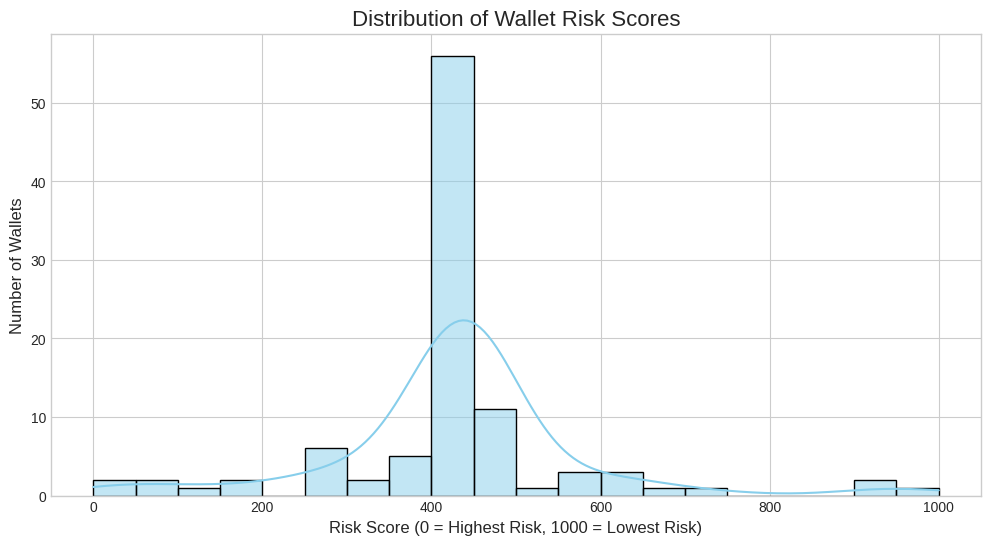

/tmp/ipython-input-30-3519739986.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')


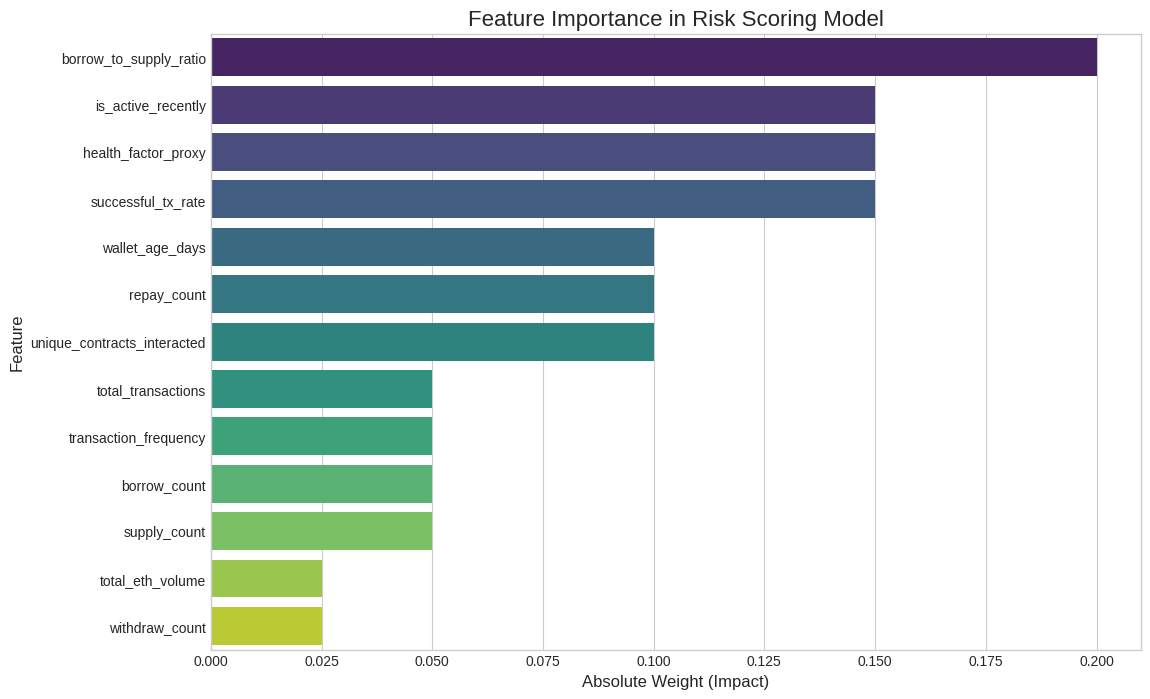

In [30]:
# --- 7. Visualization ---
print("\n--- Generating Visualizations ---")

# a. Score Distribution Histogram
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
sns.histplot(final_scores_df['score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Wallet Risk Scores', fontsize=16)
plt.xlabel('Risk Score (0 = Highest Risk, 1000 = Lowest Risk)', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.grid(True)
plt.show()

# b. Feature Importance Bar Chart
feature_importance = pd.Series({k: abs(v) for k, v in weights.items()}).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Feature Importance in Risk Scoring Model', fontsize=16)
plt.xlabel('Absolute Weight (Impact)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()
